In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid

from sklearn.manifold import TSNE
import shap
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using multi-GPU
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
torch.backends.cudnn.benchmark = False  # Disable auto-tuning for deterministic results


/home/campus.ncl.ac.uk/c1014695/miniconda3/envs/pytorch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Model

In [3]:
batch_size = 64
num_epochs = 25
num_dimensions = 30

loss_fn = nn.BCELoss()

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(num_dimensions, 100),
            nn.ReLU(),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.unsqueeze(1).float().to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = (output > 0.5).float()  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.3f}%)\n"
    )

model = Net().to(device)

## Dataset

In [6]:
encoder_epochs = 100
classes = [0,1]

class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        # Encoding from 784 (32*32) to an arbitary number of features
        # self.encoder = nn.Linear(784, encoding_dim)

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )

        # Encoding to 784 (32*32) to an arbitary number of features
        # self.decoder = nn.Linear(encoding_dim, 784)

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x
    
encoder = AutoEncoder(num_dimensions).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters())

mnist_trainset = datasets.MNIST(
    "Dataset",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

mnist_testset = datasets.MNIST(
    "Dataset",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

train_indices = [i for i, label in enumerate(mnist_trainset.targets) if label in classes]
test_indices = [i for i, label in enumerate(mnist_testset.targets) if label in classes]

train_subset = Subset(mnist_trainset, train_indices)
test_subset = Subset(mnist_testset, test_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False
)

def train_autoencoder(epoch):
    train_loss = 0.0

    for data in train_loader:
        images, _ = data

        images = images.view(images.size(0), -1)
        images = images.to(device)

        optimizer.zero_grad()

        outputs = encoder(images)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

# Run the training and testing for defined epochs
for epoch in range(encoder_epochs):
    train_autoencoder(epoch)

Epoch: 0 	Training Loss: 2.987143
Epoch: 1 	Training Loss: 1.980655
Epoch: 2 	Training Loss: 1.609803
Epoch: 3 	Training Loss: 1.382348
Epoch: 4 	Training Loss: 1.306208
Epoch: 5 	Training Loss: 1.234536
Epoch: 6 	Training Loss: 1.164006
Epoch: 7 	Training Loss: 1.115515
Epoch: 8 	Training Loss: 1.073605
Epoch: 9 	Training Loss: 1.048264
Epoch: 10 	Training Loss: 1.039164
Epoch: 11 	Training Loss: 1.027177
Epoch: 12 	Training Loss: 0.996576
Epoch: 13 	Training Loss: 0.982713
Epoch: 14 	Training Loss: 0.961470
Epoch: 15 	Training Loss: 0.930140
Epoch: 16 	Training Loss: 0.907103
Epoch: 17 	Training Loss: 0.892509
Epoch: 18 	Training Loss: 0.875176
Epoch: 19 	Training Loss: 0.822077
Epoch: 20 	Training Loss: 0.774352
Epoch: 21 	Training Loss: 0.745955
Epoch: 22 	Training Loss: 0.727370
Epoch: 23 	Training Loss: 0.713460
Epoch: 24 	Training Loss: 0.709098
Epoch: 25 	Training Loss: 0.695871
Epoch: 26 	Training Loss: 0.690534
Epoch: 27 	Training Loss: 0.670564
Epoch: 28 	Training Loss: 0.66

In [19]:
torch.save(encoder, 'Models/encoder.pth')

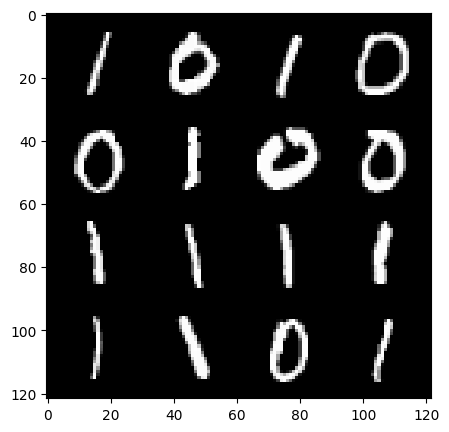

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17339838..1.18863].


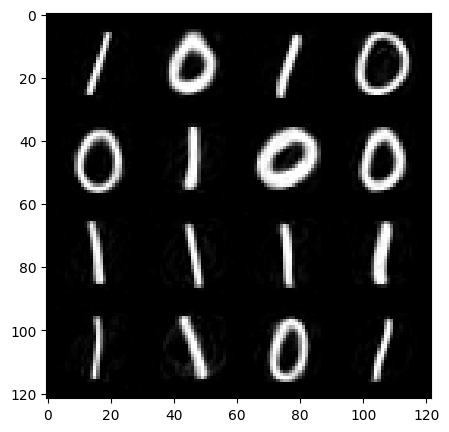

In [7]:
from torchvision.utils import make_grid
plt.rcParams["figure.figsize"] = [5, 5]

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=encoder(inputs.to(device)).to('cpu')

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

In [8]:
def encode_dataset():
    encoder.eval()
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    with torch.no_grad():
      for data, label in train_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          train_features.append(encoded.to('cpu'))
          train_labels.append(label)

      for data, label in test_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          test_features.append(encoded.to('cpu'))
          test_labels.append(label)

    return torch.cat(train_features, dim=0), torch.cat(test_features, dim=0), torch.cat(train_labels, dim=0), torch.cat(test_labels, dim=0)

features_to_train, features_to_test, labels_to_train, labels_to_test = encode_dataset()

train_dataset = torch.utils.data.TensorDataset(features_to_train, labels_to_train)
test_dataset = torch.utils.data.TensorDataset(features_to_test, labels_to_test)

encoded_dataset_full = np.concat([features_to_train.numpy(), features_to_test.numpy()])
encoded_dataset_projections = TSNE(n_components=2, random_state=0, metric='cosine').fit_transform(encoded_dataset_full)

In [9]:
encoded_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
encoded_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, encoded_trainloader, optimizer, epoch)
    test(model, device, encoded_testloader)

Train Epoch: 1 [0/12665 (0%)]	Loss: 0.694831
Train Epoch: 1 [3200/12665 (25%)]	Loss: 0.691917
Train Epoch: 1 [6400/12665 (51%)]	Loss: 0.687210
Train Epoch: 1 [9600/12665 (76%)]	Loss: 0.675626

Test set: Average loss: 0.0103, Accuracy: 1697/2115 (80.236%)

Train Epoch: 2 [0/12665 (0%)]	Loss: 0.627376
Train Epoch: 2 [3200/12665 (25%)]	Loss: 0.592021
Train Epoch: 2 [6400/12665 (51%)]	Loss: 0.538211
Train Epoch: 2 [9600/12665 (76%)]	Loss: 0.337561

Test set: Average loss: 0.0035, Accuracy: 2104/2115 (99.480%)

Train Epoch: 3 [0/12665 (0%)]	Loss: 0.294647
Train Epoch: 3 [3200/12665 (25%)]	Loss: 0.230403
Train Epoch: 3 [6400/12665 (51%)]	Loss: 0.210129
Train Epoch: 3 [9600/12665 (76%)]	Loss: 0.118981

Test set: Average loss: 0.0013, Accuracy: 2107/2115 (99.622%)

Train Epoch: 4 [0/12665 (0%)]	Loss: 0.131750
Train Epoch: 4 [3200/12665 (25%)]	Loss: 0.098000
Train Epoch: 4 [6400/12665 (51%)]	Loss: 0.102425
Train Epoch: 4 [9600/12665 (76%)]	Loss: 0.063455

Test set: Average loss: 0.0006, Accurac

In [20]:
torch.save(model, 'Models/model.pth')

## SHAP

In [11]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(encoded_testloader))
images, _ = batch

background = images[:61]
test_images = images[61:64]

model.to('cpu')

e = shap.DeepExplainer(model, background)

In [12]:
shap_values_train = e.shap_values(features_to_train)
shap_values_test = e.shap_values(features_to_test)
shap_values = np.concatenate((shap_values_train, shap_values_test), axis=0)
labels = np.concatenate((labels_to_train, labels_to_test), axis=0)

shap_values = shap_values.reshape((14780, num_dimensions))

In [17]:
shap_values.shape

(14780, 30)

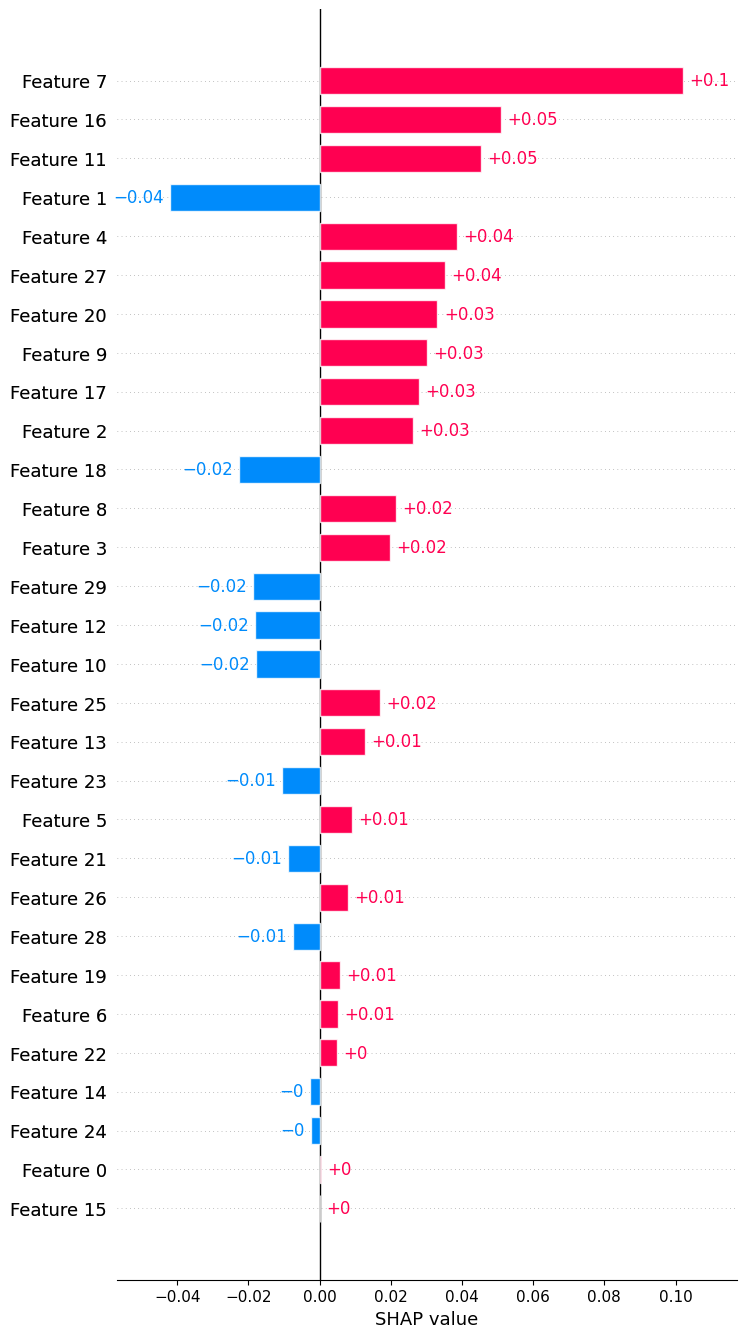

In [13]:
shap.plots.bar(shap.Explanation(shap_values[1]), max_display=num_dimensions)

In [14]:
columns = [f'feature_{x}' for x in range(0,num_dimensions)]

shap_values_df = pd.DataFrame(shap_values, columns=columns)
labels_df = pd.DataFrame(labels, columns=['class'])

shap_values_df = shap_values_df.join(labels_df)
#shap_values_df.to_csv('Data/shap_values.csv', index=None)

In [15]:
shap_values_2d = TSNE(n_components=2, random_state=0, metric='cosine').fit_transform(shap_values)

In [16]:
shap_values_2d_df = pd.DataFrame(shap_values_2d, columns=['x','y']).join(labels_df)
#shap_values_2d_df.to_csv('Data/shap_values_2d_20-features_4-2-25_FIXED-42.csv', index=None)

In [17]:
shap_values_2d_df

,x,y,class
0,-47.160130,-24.128881,0
1,22.479898,-51.934200,1
2,6.978034,78.863968,1
3,25.556274,49.504410,1
4,16.858538,62.061920,1
...,...,...,...
14775,18.397976,-60.198624,1
14776,-28.739857,21.507500,0
14777,60.598698,27.656067,1
14778,-46.974705,15.334579,0


## Quick Plot

In [20]:
shap_values_2d_df = pd.read_csv('Data/shap_values_2d.csv')

In [21]:
shap_values = shap_values_2d_df = pd.read_csv('Data/shap_values_with_coordinates.csv').drop(['class'], axis = 1)

<Axes: xlabel='x', ylabel='y'>

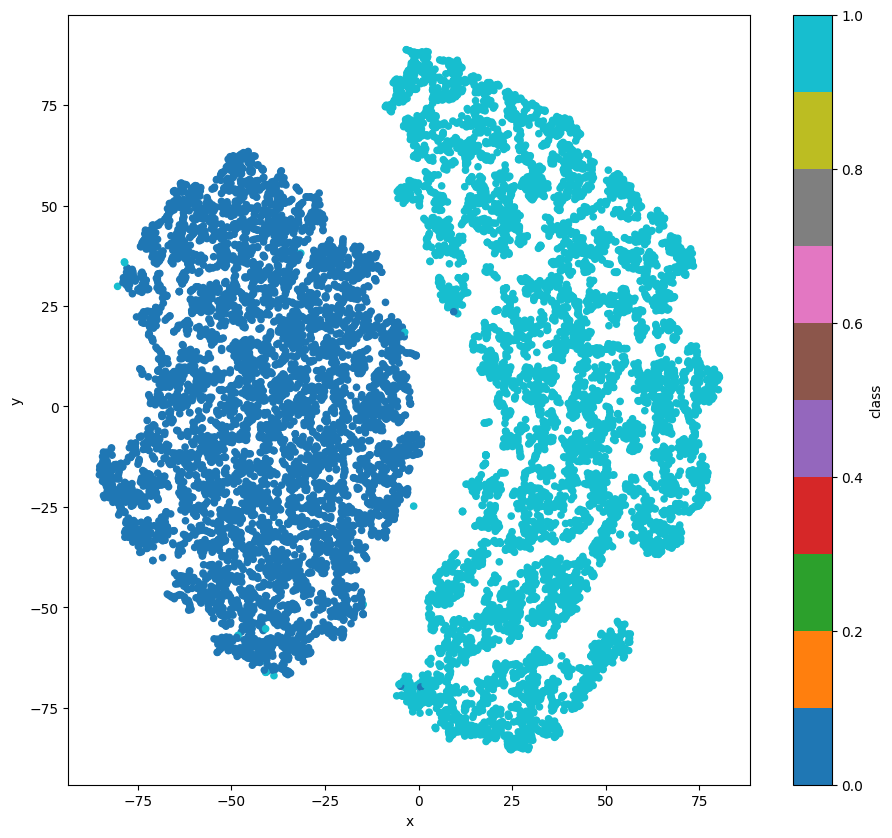

In [17]:
plt.rcParams["figure.figsize"] = [11, 10]
shap_values_2d_df.plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)

## Clustering

In [190]:
# CLUSTERS TAKEN FROM ENCODING AT 30 FEATURES

clusters_2 = [
    [18, 209, 437, 492, 588, 929, 973, 1028, 1513, 1668, 1677, 1754, 1893, 2333, 2404, 2449, 2594, 2664,3133, 3225, 3240, 3381, 3878, 3995, 4097, 4409, 4432, 4806, 4974, 5120, 5247, 5444, 5490, 5524, 6092, 6182, 6263, 6643, 6654, 6794, 6820, 7054, 7146, 7318, 7370, 7474,7545, 7597, 7810, 7827, 7840, 8209, 8380, 8635, 8640, 8809, 9155, 9528, 9662, 9664, 9972, 10263, 10589, 10692, 10764, 10767, 10773, 10774, 10775, 10781, 10788, 10791, 10796, 11040, 11545, 11876, 12195, 12273, 12670, 12863, 12974, 13120, 13300, 14105],
    [65, 397, 479, 568, 613, 752, 922, 1413, 2011, 2190, 2322, 2390, 2396, 2771, 2823, 3230, 3302, 3595, 4221, 4457, 4570, 4862, 5530, 5793, 5974, 6044, 6382, 6626, 6984, 7334, 7386, 7559,8031, 8124, 8406, 8600, 8892, 9387, 9447, 9465, 9584, 9635, 9914, 10279, 10557, 10592, 10815, 11087, 11309, 11392, 11745, 11791, 11937, 12176, 12790, 12814, 12909, 13237, 13291, 13326, 13389, 13504, 13617, 13659, 14658, 14666],
    [122, 150, 295, 721, 1362, 1644, 1786, 1806, 2143, 2259, 2292, 2623, 2628, 2630, 2632, 2642, 2650, 2749, 2765, 2770, 2777, 2779, 2781, 2790, 2806, 2815, 2818, 2844, 2959, 3274, 3339, 3345, 3419, 3970, 4043, 4374, 4797, 4816, 4817, 4884, 4907, 4910, 5056, 6204, 6208, 6364, 6367, 6371, 6385, 6397, 6400, 6405, 6409, 6415, 6420, 6653, 6673, 6894, 6897, 7009, 7013, 7062, 7063, 7261, 7262, 7372, 7403, 7531, 7638, 7656, 7657, 7787, 7825, 8092, 8171, 8177, 8323, 8330, 8340, 8352, 8540, 8547, 8620, 8663, 8671, 8678, 8777, 8780, 8798, 8803, 8810, 8816, 8819, 8835, 8859, 9188, 9191, 9210, 9216, 9378, 9384, 9389, 9432, 10424, 10428, 10431, 10433, 10441, 10443, 10498, 10512, 10518, 10520, 11037, 11061, 11439, 11618, 11633, 12153, 12167, 12169, 12526, 12613, 12656, 14232, 14561, 14723]
]

In [192]:
model.fc_layers

Sequential(
  (0): Linear(in_features=30, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.4, inplace=False)
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=100, out_features=1, bias=True)
  (15): Sigmoid()
)

In [193]:
def get_activation(model):
    activations = [[],[],[],[]]

    def hook1(model, input, output):
        activations[0].append(output.detach().numpy())

    def hook2(model, input, output):
        activations[1].append(output.detach().numpy())

    def hook3(model, input, output):
        activations[2].append(output.detach().numpy())

    def hook4(model, input, output):
        activations[3].append(output.detach().numpy())

    hooks = []
    hooks.append(model.fc_layers[3].register_forward_hook(hook1))
    hooks.append(model.fc_layers[6].register_forward_hook(hook2))
    hooks.append(model.fc_layers[9].register_forward_hook(hook3))
    hooks.append(model.fc_layers[12].register_forward_hook(hook4))
            
    return activations, hooks

In [199]:
cluster_num = 1
activations, hooks = get_activation(model)

for id in clusters_2[cluster_num]:
    out = model(torch.Tensor(encoded_dataset_full[id]))
activations = np.array(activations)

In [201]:
layer_num = 0
trans_activations = activations[layer_num].transpose()
trans_activations.shape

(100, 66)

In [202]:
shap_snip = pd.read_csv('Data/shap_values.csv').drop(['class'], axis=1)
top_10_entries = []
class_leaning = []
top_10_average = []
neuron_shap_vectors_m1 = [] # Method One - Vector from Top 3 SHAP values for each header across all values
neuron_shap_vectors_m2 = [] # Method Two - Vector from the SHAP values of the top 3 activations

for x in range(0,len(trans_activations)):
    top_10 = np.argsort(trans_activations[x])[-10:][::-1]
    top_10_set = top_10[0:10]
    top_10_values = trans_activations[top_10]

    top_10_average.append(np.average(top_10_values))

    top_10_entries.append(top_10_set)
    shap_values_set = shap_snip.loc[top_10_set]

    neuron_shap_vectors_m1.append([shap_values_set[col].nlargest(3).values for col in shap_snip.columns])
    neuron_shap_vectors_m2.append([shap_values_set[col].iloc[:3].values for col in shap_snip.columns ])

    classes = [labels[clusters_2[cluster_num][z]] for z in top_10_set] # CHANGE THIS VALUE DEPENDING ON THE CLUSTER
    class_leaning.append(sum(classes)/len(classes))


In [203]:
similarity_matrix = []

def jacard(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

for x in range(0, len(top_10_entries)):
    similarity_scores = []
    for z in range(0, len(top_10_entries)):
        if x == z:
            similarity_scores.append(1)
        else:
            similarity_scores.append(jacard(set(top_10_entries[x]), set(top_10_entries[z])))
    similarity_matrix.append(similarity_scores)

similarity_matrix = np.array(similarity_matrix)
#np.save('Matrices/cluster_one_similarity', similarity_matrix)

In [204]:
reduced_sim_matrix = TSNE(n_components=2, metric='cosine', random_state=0, perplexity=10).fit_transform(similarity_matrix)

In [205]:
class_leaning_df = pd.DataFrame(class_leaning, columns=['class_association'])
average_activation_df = pd.DataFrame(top_10_average, columns=['average_activation'])
top_10_entries_df = pd.DataFrame(top_10_entries, columns=[f'activation_{x}' for x in range(0, 10)])

coordinates = pd.DataFrame(reduced_sim_matrix, columns=['x','y']).join(class_leaning_df).join(top_10_entries_df).join(average_activation_df)
coordinates

,x,y,class_association,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,average_activation
0,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
1,18.249987,11.146194,0.1,51,9,43,13,14,60,30,34,10,6,0.355027
2,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
3,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
4,-2.717016,-3.645230,0.1,14,15,36,31,56,24,55,65,64,61,0.277814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-25.423494,-7.086464,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
96,1.127984,-0.711067,0.3,14,27,58,26,29,2,3,31,61,24,0.213125
97,-24.596706,-12.033295,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
98,2.704217,2.947125,0.0,28,26,42,2,11,63,35,49,0,21,0.127683


In [93]:
coordinates.to_csv('Data/Neuron_Cluster_Third_Hidden_Layer.csv', index_label='ind')

<Axes: xlabel='x', ylabel='y'>

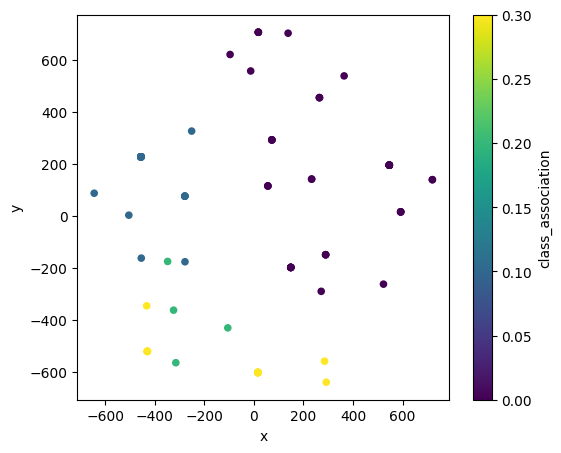

In [92]:
plt.rcParams["figure.figsize"] = [6,5]

coordinates.plot.scatter(
    x='x',
    y='y',
    c='class_association'
)

## Network-Wide Jacard

In [172]:
first = pd.read_csv('Data/Neuron_Cluster_First_Hidden_Layer.csv')
first['layer'] = 1

second = pd.read_csv('Data/Neuron_Cluster_Second_Hidden_Layer.csv')
second['ind'] = second['ind'] + 100
second['layer'] = 2

third = pd.read_csv('Data/Neuron_Cluster_Third_Hidden_Layer.csv')
third['ind'] = third['ind'] + 200
third['layer'] = 3

fourth = pd.read_csv('Data/Neuron_Cluster_Last_Hidden_Layer.csv')
fourth['ind'] = fourth['ind'] + 300
fourth['layer'] = 4

In [173]:
first

,ind,x,y,class_association,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,average_activation,layer
0,0,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
1,1,18.249987,11.146194,0.1,51,9,43,13,14,60,30,34,10,6,0.355027,1
2,2,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
3,3,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
4,4,-2.717016,-3.645230,0.1,14,15,36,31,56,24,55,65,64,61,0.277814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,-25.423494,-7.086464,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
96,96,1.127984,-0.711067,0.3,14,27,58,26,29,2,3,31,61,24,0.213125,1
97,97,-24.596706,-12.033295,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
98,98,2.704217,2.947125,0.0,28,26,42,2,11,63,35,49,0,21,0.127683,1


In [174]:
second

,ind,x,y,class_association,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,average_activation,layer
0,100,-7.243618,-90.81181,0.0,51,43,60,9,6,30,50,10,13,12,0.094862,2
1,101,182.094160,-107.63179,0.1,65,64,63,62,61,60,59,58,57,56,0.417327,2
2,102,296.040500,-148.76819,0.1,65,64,63,62,61,60,59,58,57,56,0.417327,2
3,103,211.811300,-147.31133,0.1,65,64,63,62,61,60,59,58,57,56,0.417327,2
4,104,160.870940,178.76290,0.2,27,29,64,65,63,62,59,58,61,60,0.713199,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,195,-258.957500,-119.30747,0.0,43,51,60,30,6,20,64,50,18,9,0.174703,2
96,196,-100.335310,-226.42383,0.0,51,43,60,9,6,30,50,20,10,12,0.094862,2
97,197,96.062730,226.91919,0.2,14,61,29,31,27,65,64,63,62,60,0.717446,2
98,198,215.746170,-181.78554,0.1,65,64,63,62,61,60,59,58,57,56,0.417327,2


In [175]:
full = pd.concat([first, second, third, fourth]).reset_index().drop('index', axis=1)
activations = full[[f'activation_{x}' for x in range(0,10)]]

In [176]:
full

,ind,x,y,class_association,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,average_activation,layer
0,0,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
1,1,18.249987,11.146194,0.1,51,9,43,13,14,60,30,34,10,6,0.355027,1
2,2,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
3,3,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353,1
4,4,-2.717016,-3.645230,0.1,14,15,36,31,56,24,55,65,64,61,0.277814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,19.099560,-363.098600,0.2,27,58,29,65,64,63,60,59,61,62,1.033368,4
396,396,331.213260,-264.488620,0.3,27,58,29,14,61,31,64,65,62,63,0.828995,4
397,397,-361.688100,-402.990720,0.1,65,64,63,62,61,60,59,58,57,56,0.806644,4
398,398,66.345770,-410.627470,0.2,27,58,29,65,64,63,60,59,61,62,1.033368,4


In [114]:
activations = activations.to_numpy()
full_similarity_matrix = []

def jacard(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

for x in range(0, len(activations)):
    similarity_scores = []
    for z in range(0, len(activations)):
        if x == z:
            similarity_scores.append(1)
        else:
            similarity_scores.append(jacard(set(activations[x]), set(activations[z])))
    full_similarity_matrix .append(similarity_scores)

full_similarity_matrix  = np.array(full_similarity_matrix )

In [118]:
reduced_sim_matrix = TSNE(n_components=2, metric='cosine', random_state=0, perplexity=10).fit_transform(full_similarity_matrix)

In [180]:
coordinates = pd.DataFrame(reduced_sim_matrix, columns=['x','y'])

In [181]:
info = full[['class_association', 'average_activation', 'layer']]

In [182]:
activations.join(info)

,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,class_association,average_activation,layer
0,65,64,63,62,61,60,59,58,57,56,0.1,0.255353,1
1,51,9,43,13,14,60,30,34,10,6,0.1,0.355027,1
2,65,64,63,62,61,60,59,58,57,56,0.1,0.255353,1
3,65,64,63,62,61,60,59,58,57,56,0.1,0.255353,1
4,14,15,36,31,56,24,55,65,64,61,0.1,0.277814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,27,58,29,65,64,63,60,59,61,62,0.2,1.033368,4
396,27,58,29,14,61,31,64,65,62,63,0.3,0.828995,4
397,65,64,63,62,61,60,59,58,57,56,0.1,0.806644,4
398,27,58,29,65,64,63,60,59,61,62,0.2,1.033368,4


In [166]:
info

,class_association,average_activation
0,0.1,0.255353
1,0.1,0.355027
2,0.1,0.255353
3,0.1,0.255353
4,0.1,0.277814
...,...,...
395,0.2,1.033368
396,0.3,0.828995
397,0.1,0.806644
398,0.2,1.033368


In [183]:
coordinates = coordinates.join(activations).join(info)

In [184]:
coordinates

,x,y,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,class_association,average_activation,layer
0,-8.827518,38.341122,65,64,63,62,61,60,59,58,57,56,0.1,0.255353,1
1,3.954805,-7.142654,51,9,43,13,14,60,30,34,10,6,0.1,0.355027,1
2,-8.827518,38.341122,65,64,63,62,61,60,59,58,57,56,0.1,0.255353,1
3,-8.827518,38.341122,65,64,63,62,61,60,59,58,57,56,0.1,0.255353,1
4,-32.432678,-10.443572,14,15,36,31,56,24,55,65,64,61,0.1,0.277814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-35.426262,-4.416243,27,58,29,65,64,63,60,59,61,62,0.2,1.033368,4
396,-42.582260,-27.766899,27,58,29,14,61,31,64,65,62,63,0.3,0.828995,4
397,-3.731522,26.478416,65,64,63,62,61,60,59,58,57,56,0.1,0.806644,4
398,-36.168983,-3.459471,27,58,29,65,64,63,60,59,61,62,0.2,1.033368,4


In [185]:
coordinates.to_csv('Data/Neuron_Cluster_All_Layers.csv')

<Axes: xlabel='x', ylabel='y'>

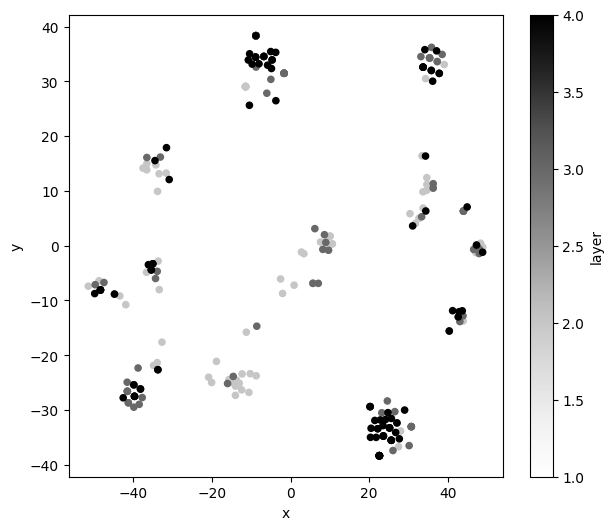

In [187]:
plt.rcParams["figure.figsize"] = [7,6]

coordinates.plot.scatter(
    x='x',
    y='y',
    c='average_activation'
)